# MNIST with Convolutional Neural Network

To train regular neural network with images, we have been rescaling two dimensional image into one dimensional array. This means, we are losing a lot of information about relations between the pixels, which might lead to worse performance. Convolutional Neural networks are here to counter this issue down by keeping the relations between two (or more) dimensions of the input data, all while increasing the performance.

MLP
    - only use fully connected layers
    - only accept vectors as input
    
CNN
    - also use sparsely connected layers

MLPs | CNNs
--- | ---
<img src="./neural_net2.jpeg" width="400" height="200" /> | <img src="./cnn.jpeg" width="400" height="200" />
<center>Image source: http://cs231n.github.io/convolutional-networks/</center>

In CNN, we can use `parameter sharing` between neurons to dramaticaly reduce number of parameters in the network. Parameter sharing can be used, because it's clear that if something is working for the pixel in the middle of an image, it will also work for another pixel of the image.

MLP | CNN
--- | ---
<img src="./mnist-dense.png" width="400" height="200" /> | <img src="./cnn-mnist.png" width="400" height="200" />


### Convolutional Layer
Convolutional layer is set of filters, instead of clasic neurons, that are connected to the input layer. These filters then serve as neurons and have weights on their synapsis. Filters has their own width, height (in practice height and width are the same) and depth. Depth is equal to the number of channels in the image, so if we have a colored image, the depth is three (red, green, and blue).

In convulutional layer we are working with <b>convolutional windows</b>. By sliding the window over the image we get new image with enhanced edges.

![cnn_widnow.gif](./cnn_widnow.gif)
<center>Image source: http://cs231n.github.io/convolutional-networks/</center>

New image is calucalted by multiplying its matrix value with corresponding filter and then summing it up.

<img src="./applying-filter.png" width="500" height="300" />

$$
 RELU\Bigg(SUM\Bigg(\begin{matrix}
  0*0 & 1*1 & 0*0 \\
  0*0 & 1*1 & 0*0 \\
  0*0 & 1*1 & 0*0
 \end{matrix}\Bigg)\Bigg) = 3 
$$

Various filters are used to enhance various edges.

<img src="./filters.png" width="450" height="250" />

By applying a filter, we are reducing the size of the image (height and width), but 'cause we are using multiple filters for each layer, we are significantly increasing its depth.

<img src="./increasgin-depth.png" width="400" height="200" />
<center>Image source: https://keunwoochoi.wordpress.com/author/keunwoochoi/page/5/</center>
    
Sample of apyling some filters on the image and visualizing the edges:
<img src="./car-filters.png" width="600" height="400" />
<center>Image source: https://github.com/udacity/aind2-cnn/blob/master/conv-visualization/conv_visualization.ipynb</center>
  
Convolutional widnows have multiple parameters, that can dramaticaly change the behviour of the network:

- `Widnow size` is the width and height of the sliding window
- `Strides` offset in pixels to move the window (most commonly set to 1 or 2)
- `Padding` in case the `Strides` is greather than one, we need to decide what to do with pixels around the edges. We have two options:
    - get rid of them: `valid`
    - fill with zeros: `same`

### Max Pooling

Pooling helps us futher decrease number of parameters and prevent overfitting by downsampling the next representation of an image. It's common to pooling layer after each convolutional layer.
There are multiple poolings variant:
- `max pooling` is using window to chose a max value for the new cell of a matrix
- `average pooling` averages the values of the widnow
- `global average pooling` averages the value over whole layer

<img src="./maxpool.jpeg" width="400" height="200" />
<center>Image source: http://cs231n.github.io/convolutional-networks/</center>

### Load MNIST

In [1]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print("The MNIST database has a training set of %d examples." % len(train_images))
print("The MNIST database has a test set of %d examples." % len(test_images))

Using TensorFlow backend.


The MNIST database has a training set of 60000 examples.
The MNIST database has a test set of 10000 examples.


### Rescale
Aditionaly to the rescale from <0,255> is convient for CNN to add chanel. We are using only one color for the training so the chanel is 1. In real world scenarios we will have 3 channels (RGB).
MNIST dataset doesn't come with the chanel so we need to reshape it with one.

In [2]:
scaled_train_images = train_images.astype('float32') / 255
scaled_test_images = test_images.astype('float32') / 255

scaled_train_images = scaled_train_images.reshape(scaled_train_images.shape[0], 28, 28, 1)
scaled_test_images = scaled_test_images.reshape(scaled_test_images.shape[0], 28, 28, 1)

### One Hot encoding

In [3]:
from keras.utils import np_utils

print('Integer-valued labels:')
print(train_labels[:10])

# one-hot encode the labels
train_labels = np_utils.to_categorical(train_labels, 10)
test_labels = np_utils.to_categorical(test_labels, 10)

# print first ten (one-hot) training labels
print('One-hot labels:')
print(test_labels[:10])

Integer-valued labels:
[5 0 4 1 9 2 1 3 1 4]
One-hot labels:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### Define the model

We are using Adam (`adaptive moment estimation`) as an optimizer, 'cause Adam works really great with convolutional neural networks.

Adam principle is in keeping the learning rate for each synapsis, and gradualy chaning it depended on the loss size. 

In [4]:
import keras.backend as K

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten

# define the model
K.clear_session()
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu',
                 input_shape=(28, 28, 1)))  # 28 x 28 are images from MNIST plus 1 chanel (grey)
model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters=28, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))  
model.add(Conv2D(filters=56, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

# summarize the model
model.summary()

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 56)        3640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 56)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 56)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2744)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1372500   
__________

### Training

In [5]:
from keras.callbacks import ModelCheckpoint

# train the model
checkpointer = ModelCheckpoint(filepath='mnist.model.best.hdf5',
                               verbose=1, save_best_only=True)

hist = model.fit(scaled_train_images, train_labels, batch_size=128, epochs=10,
                 validation_split=0.2, callbacks=[checkpointer],
                 verbose=1, shuffle=True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 23s 482us/step - loss: 0.2969 - acc: 0.9095 - val_loss: 0.0845 - val_acc: 0.9752

Epoch 00001: val_loss improved from inf to 0.08447, saving model to mnist.model.best.hdf5
Epoch 2/10
48000/48000 [==============================] - 22s 451us/step - loss: 0.0983 - acc: 0.9693 - val_loss: 0.0613 - val_acc: 0.9808

Epoch 00002: val_loss improved from 0.08447 to 0.06125, saving model to mnist.model.best.hdf5
Epoch 3/10
48000/48000 [==============================] - 23s 489us/step - loss: 0.0693 - acc: 0.9782 - val_loss: 0.0485 - val_acc: 0.9859

Epoch 00003: val_loss improved from 0.06125 to 0.04848, saving model to mnist.model.best.hdf5
Epoch 4/10
48000/48000 [==============================] - 23s 480us/step - loss: 0.0545 - acc: 0.9828 - val_loss: 0.0422 - val_acc: 0.9869

Epoch 00004: val_loss improved from 0.04848 to 0.04218, saving model to mnist.model.best.hdf5
Epoch 5/10
48000/4

### Evaluation

In [6]:
from keras.models import load_model

model = load_model('mnist.model.best.hdf5')

score = model.evaluate(scaled_test_images, test_labels, verbose=0)
accuracy = 100 * score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 99.1200%


### Sample predictions

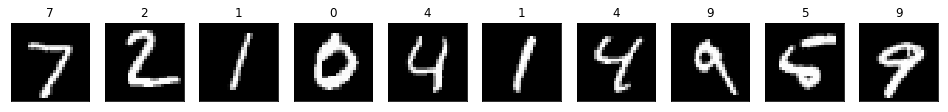

In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

start = 15
end = 25
fig = plt.figure(figsize=(20, 20))

for i in range(end-start):
    prediction = int(model.predict(np.expand_dims(scaled_test_images[i], axis=0)).argmax())
    display_image = test_images[i]
    ax = fig.add_subplot(3, 12, i+1, xticks=[], yticks=[])
    ax.imshow(display_image, cmap='gray')
    ax.set_title(str(prediction))

### Importance of visualization

When working with something abstact, like neural networks where we are working with thousands of samples, we really need to keep on visualizing the process which helps us to significantly improve architecture and find potentional issues in our code. 

Here is a sample of visualizing what is important for the neurons while looking at the pixels, when they are trying to decide a class.

<img src="./softmax-weights.png" width="600" height="400" />
<center>Image source: https://www.tensorflow.org/versions/r1.0/get_started/mnist/beginners</center>

## Your tasks

Now here are tasks that you should do to get a little more familiar with this example:
1. Change the parameters of the neural network - sizes of the convolutional layers etc.
2. Add another convolutional layer or uncomment the commented code in the neural network
3. Try to "cripple" the network as much as you can, to have for example accuracy around 50%. E.g. try increasing the dropout layers percentage to see what they are doing.